# Analyse LSTM - Prédictions de Prix SPY

Ce notebook analyse les performances du modèle LSTM pour la prédiction des prix de l'ETF SPY.

## Objectifs
- Charger et analyser les données de prix SPY
- Évaluer les performances du modèle LSTM
- Visualiser les prédictions historiques et futures
- Analyser les métriques de performance


In [1]:
# Imports et configuration
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Ajout du répertoire racine au path
sys.path.append('/Users/eagle/DevTools/sentinel')

# =============================================================================
# CONFIGURATION CENTRALISÉE DE L'ANALYSE LSTM
# =============================================================================

# Période d'analyse
ANALYSIS_START_YEAR = 2020  # Année de début de l'analyse (modifiable)
ANALYSIS_YEARS = 5  # Nombre d'années à analyser

# Paramètres de prédiction
PREDICTION_HORIZON = 10  # Nombre de jours à prédire
SIMPLE_PREDICTION_HORIZON = 1  # Prédiction simple (1 jour)

# Seuils de performance
SUCCESS_THRESHOLD = 0.02  # 2% - seuil de réussite des prédictions
RECENT_DAYS_DISPLAY = 5  # Nombre de jours récents à afficher
RECENT_30_DAYS = 30  # Période pour analyse récente
RECENT_90_DAYS = 90  # Période pour analyse récente

# Configuration des graphiques
FIGURE_SIZE_MAIN = (15, 10)  # Taille des graphiques principaux
FIGURE_SIZE_FINAL = (16, 12)  # Taille du graphique final
FIGURE_SIZE_ERROR = (12, 6)  # Taille du graphique d'erreurs

# Ticker analysé
TICKER = "SPY"  # Symbole du ticker à analyser

# Période de filtrage récent
RECENT_PERIOD = "1 mois"  # Période pour les données récentes

print(f"📁 Répertoire racine: {os.getcwd()}")
print(f"🐍 Python: {sys.version}")
print(f"🔥 PyTorch: {__import__('torch').__version__}")
print(f"📊 Configuration: Analyse de {ANALYSIS_YEARS} ans à partir de {ANALYSIS_START_YEAR}")


📁 Répertoire racine: /Users/eagle/DevTools/sentinel/tools/gui/pages
🐍 Python: 3.12.11 (main, Sep  2 2025, 14:12:30) [Clang 20.1.4 ]
🔥 PyTorch: 2.8.0
📊 Configuration: Analyse de 5 ans à partir de 2020


In [2]:
# Initialisation des services
from tools.gui.services.data_service import DataService
from tools.gui.services.prediction_service import PredictionService

# Création des instances
data_service = DataService()
prediction_service = PredictionService()

print("✅ Services initialisés")


2025-09-23 16:02:01.358 | INFO     | tools.gui.services.data_service:__init__:18 - 📊 Service de données initialisé
2025-09-23 16:02:01.359 | INFO     | tools.gui.services.prediction_service:__init__:79 - 🤖 Service de prédiction LSTM initialisé


✅ Services initialisés


In [3]:
# Chargement des données SPY
data = data_service.load_data(TICKER)

if data is not None and not data.empty:
    print(f"📊 Données {TICKER} chargées: {len(data)} lignes")
    print(f"📅 Période: {data['DATE'].iloc[0]} à {data['DATE'].iloc[-1]}")
    print(f"💰 Prix: ${data['CLOSE'].iloc[0]:.2f} → ${data['CLOSE'].iloc[-1]:.2f}")
else:
    print(f"❌ Impossible de charger les données pour {TICKER}")


2025-09-23 16:02:01.524 | INFO     | tools.gui.services.data_service:load_data:45 - ✅ Données chargées pour SPY: 6721 lignes


📊 Données SPY chargées: 6721 lignes
📅 Période: 1999-01-04 00:00:00-05:00 à 2025-09-22 00:00:00-04:00
💰 Prix: $76.90 → $666.84


In [4]:
# Filtrage des données pour la période récente + Prédictions sur l'historique complet
filtered_data = data_service.filter_by_period(data, RECENT_PERIOD)

if filtered_data is not None and not filtered_data.empty:
    print(f"🔍 Données filtrées ({RECENT_PERIOD}): {len(filtered_data)} lignes")
    print(f"📅 Période filtrée: {filtered_data['DATE'].iloc[0]} à {filtered_data['DATE'].iloc[-1]}")
    print(f"💰 Prix: ${filtered_data['CLOSE'].iloc[0]:.2f} → ${filtered_data['CLOSE'].iloc[-1]:.2f}")
else:
    print("❌ Impossible de filtrer les données")

# Prédictions sur l'historique complet (période configurable)
print(f"\n📊 Prédictions sur l'historique complet ({ANALYSIS_YEARS} ans)...")
# Filtrer pour la période configurée
start_date = pd.Timestamp(f'{ANALYSIS_START_YEAR}-01-01')
end_date = pd.Timestamp(f'{ANALYSIS_START_YEAR + ANALYSIS_YEARS}-12-31')

# Gérer les timezones pour éviter les erreurs de comparaison
if data['DATE'].dt.tz is not None:
    # Si les dates ont une timezone, normaliser
    data_clean = data.copy()
    data_clean['DATE'] = data_clean['DATE'].dt.tz_localize(None)
else:
    data_clean = data.copy()

# Filtrer les données
historical_data = data_clean[
    (data_clean['DATE'] >= start_date) & 
    (data_clean['DATE'] <= end_date)
].copy()

print(f"📈 Données historiques ({ANALYSIS_YEARS} ans): {len(historical_data)} lignes")
if len(historical_data) > 0:
    print(f"📅 Période: {historical_data['DATE'].iloc[0].strftime('%d/%m/%Y')} à {historical_data['DATE'].iloc[-1].strftime('%d/%m/%Y')}")
    print(f"📊 Durée: {len(historical_data)} jours de trading sur {ANALYSIS_YEARS} ans")
else:
    print("❌ Aucune donnée trouvée pour la période sélectionnée")


2025-09-23 16:02:01.531 | INFO     | tools.gui.services.data_service:filter_by_period:88 - ✅ Filtrage 1 mois: 20 lignes


🔍 Données filtrées (1 mois): 20 lignes
📅 Période filtrée: 2025-08-25 00:00:00-04:00 à 2025-09-22 00:00:00-04:00
💰 Prix: $640.69 → $666.84

📊 Prédictions sur l'historique complet (5 ans)...
📈 Données historiques (5 ans): 1438 lignes
📅 Période: 02/01/2020 à 22/09/2025
📊 Durée: 1438 jours de trading sur 5 ans


In [5]:
# Chargement du modèle LSTM
success = prediction_service.load_model()
print(f"🤖 Modèle chargé: {success}")

if success:
    print(f"✅ Modèle LSTM SPY chargé avec succès")
    print(f"🔧 Device: {prediction_service.device}")
    print(f"📊 Modèle prêt: {prediction_service.is_loaded}")
else:
    print("❌ Impossible de charger le modèle")


2025-09-23 16:02:01.538 | INFO     | tools.gui.services.prediction_service:load_model:106 - 🔍 Dernière version trouvée: 4
2025-09-23 16:02:01.545 | INFO     | tools.gui.services.prediction_service:load_model:143 - ✅ Modèle LSTM SPY v4 chargé avec succès


🤖 Modèle chargé: True
✅ Modèle LSTM SPY chargé avec succès
🔧 Device: cpu
📊 Modèle prêt: True


In [6]:
# Préparation des features pour le modèle
features = prediction_service.prepare_features(filtered_data)

if features is not None:
    print(f"🔧 Features préparées: {features.shape}")
    print(f"📊 Type: {type(features)}")
    print(f"📈 Min: {features.min():.6f}")
    print(f"📈 Max: {features.max():.6f}")
    print(f"📈 Mean: {features.mean():.6f}")
    print(f"📈 Std: {features.std():.6f}")
    print("✅ Features cohérentes avec les données")
else:
    print("❌ Impossible de préparer les features")


2025-09-23 16:02:01.558 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (20, 15) avec 15 features


🔧 Features préparées: (20, 15)
📊 Type: <class 'numpy.ndarray'>
📈 Min: -3.149749
📈 Max: 2.224182
📈 Mean: 0.000000
📈 Std: 0.999997
✅ Features cohérentes avec les données


In [7]:
# Prédiction simple
if features is not None and len(features) >= 10:
    # Utiliser la méthode predict avec un horizon configuré
    predictions = prediction_service.predict(filtered_data, horizon=SIMPLE_PREDICTION_HORIZON)
    
    if predictions is not None and 'error' not in predictions:
        future_preds = predictions['predictions']
        future_dates = predictions['prediction_dates']
        current_price = filtered_data['CLOSE'].iloc[-1]
        
        if future_preds and len(future_preds) > 0:
            # Prendre la première prédiction future
            predicted_price = future_preds[0]
            prediction_date = future_dates[0]
            prediction_change = (predicted_price - current_price) / current_price
            
            print(f"🔍 Données utilisées: {len(filtered_data)} lignes")
            print(f"💰 Prix actuel: ${current_price:.2f}")
            print(f"🔮 Prix prédit: ${predicted_price:.2f}")
            print(f"📊 Variation: {prediction_change * 100:.2f}%")
            print(f"📅 Date prédite: {prediction_date}")
        else:
            print("❌ Aucune prédiction future générée")
    elif predictions and 'error' in predictions:
        print(f"❌ Erreur de prédiction: {predictions['error']}")
    else:
        print("❌ Impossible de faire la prédiction")
else:
    print("❌ Pas assez de données pour la prédiction")


2025-09-23 16:02:01.572 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (20, 15) avec 15 features
2025-09-23 16:02:01.581 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (20, 15) avec 15 features
2025-09-23 16:02:01.582 | INFO     | tools.gui.services.prediction_service:predict:377 - ✅ Prédiction LSTM: 20 prédictions historiques + 1 prédictions futures


🔍 Données utilisées: 20 lignes
💰 Prix actuel: $666.84
🔮 Prix prédit: $667.25
📊 Variation: 0.06%
📅 Date prédite: 2025-09-23


In [8]:
# Prédictions sur l'historique complet
print("🔄 Prédictions sur l'historique complet...")
historical_predictions = prediction_service.predict(historical_data, horizon=PREDICTION_HORIZON)

if historical_predictions is not None and 'error' not in historical_predictions:
    print("✅ Prédictions historiques complètes réussies!")
    print(f"📊 Données historiques: {len(historical_data)} lignes")
    print(f"📊 Prédictions générées: {len(historical_predictions['historical_predictions'])}")
    print(f"📊 Prédictions futures: {len(historical_predictions['predictions'])}")
    
    # Afficher quelques exemples de prédictions historiques
    hist_preds = historical_predictions['historical_predictions']
    real_prices_hist = historical_data['CLOSE']
    
    print(f"\n📈 Exemples de prédictions historiques ({RECENT_DAYS_DISPLAY} dernières):")
    for idx, i in enumerate(range(-RECENT_DAYS_DISPLAY, 0), 1):
        real_price = real_prices_hist.iloc[i]
        pred_price = hist_preds[i]
        error = abs(real_price - pred_price)
        date = historical_data['DATE'].iloc[i]
        print(f"    {idx}. {date.strftime('%Y-%m-%d')}: Réel ${real_price:.2f} | Prédit ${pred_price:.2f} | Erreur ${error:.2f}")
else:
    print("❌ Erreur dans les prédictions historiques complètes")

# Prédictions complètes (historiques + futures) sur la période récente
print(f"\n🔄 Prédictions sur la période récente ({RECENT_PERIOD})...")
if features is not None:
    # Faire les prédictions
    predictions = prediction_service.predict(filtered_data, horizon=PREDICTION_HORIZON)
    
    if predictions is not None and 'error' not in predictions:
        historical_preds = predictions['historical_predictions']
        future_preds = predictions['predictions']
        future_dates = predictions['prediction_dates']
        
        print("✅ Prédiction réussie!")
        print(f"📊 Prix réels: {len(filtered_data)}")
        print(f"📊 Prédictions historiques: {len(historical_preds)}")
        print(f"📊 Prédictions futures: {len(future_preds)}")
        
        print("\n🔮 Prédictions futures:")
        for i, (date, price) in enumerate(zip(future_dates, future_preds), 1):
            print(f"    {i:2d}. {date}: ${price:.2f}")
        
        print(f"\n📈 Prédictions historiques récentes ({RECENT_DAYS_DISPLAY} dernières):")
        for idx, i in enumerate(range(-RECENT_DAYS_DISPLAY, 0), 1):
            real_price = filtered_data['CLOSE'].iloc[i]
            pred_price = historical_preds[i]
            error = abs(real_price - pred_price)
            print(f"    {idx:2d}. Réel: ${real_price:.2f} | Prédit: ${pred_price:.2f} | Erreur: ${error:.2f}")
    elif predictions and 'error' in predictions:
        print(f"❌ Erreur de prédiction: {predictions['error']}")
    else:
        print("❌ Impossible de faire les prédictions")
else:
    print("❌ Pas de features disponibles")


2025-09-23 16:02:01.597 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (1438, 15) avec 15 features


🔄 Prédictions sur l'historique complet...


2025-09-23 16:02:01.912 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (1438, 15) avec 15 features
2025-09-23 16:02:01.915 | INFO     | tools.gui.services.prediction_service:predict:377 - ✅ Prédiction LSTM: 1438 prédictions historiques + 10 prédictions futures
2025-09-23 16:02:01.922 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (20, 15) avec 15 features
2025-09-23 16:02:01.930 | INFO     | tools.gui.services.prediction_service:prepare_features:219 - ✅ Features optimisées préparées: (20, 15) avec 15 features
2025-09-23 16:02:01.933 | INFO     | tools.gui.services.prediction_service:predict:377 - ✅ Prédiction LSTM: 20 prédictions historiques + 10 prédictions futures


✅ Prédictions historiques complètes réussies!
📊 Données historiques: 1438 lignes
📊 Prédictions générées: 1438
📊 Prédictions futures: 10

📈 Exemples de prédictions historiques (5 dernières):
    1. 2025-09-16: Réel $658.18 | Prédit $659.20 | Erreur $1.02
    2. 2025-09-17: Réel $657.36 | Prédit $658.31 | Erreur $0.96
    3. 2025-09-18: Réel $660.43 | Prédit $657.50 | Erreur $2.93
    4. 2025-09-19: Réel $663.70 | Prédit $660.62 | Erreur $3.08
    5. 2025-09-22: Réel $666.84 | Prédit $663.92 | Erreur $2.92

🔄 Prédictions sur la période récente (1 mois)...
✅ Prédiction réussie!
📊 Prix réels: 20
📊 Prédictions historiques: 20
📊 Prédictions futures: 10

🔮 Prédictions futures:
     1. 2025-09-23: $667.25
     2. 2025-09-24: $667.66
     3. 2025-09-25: $668.06
     4. 2025-09-26: $668.47
     5. 2025-09-27: $668.88
     6. 2025-09-28: $669.29
     7. 2025-09-29: $669.70
     8. 2025-09-30: $670.11
     9. 2025-10-01: $670.52
    10. 2025-10-02: $670.93

📈 Prédictions historiques récentes (5 de

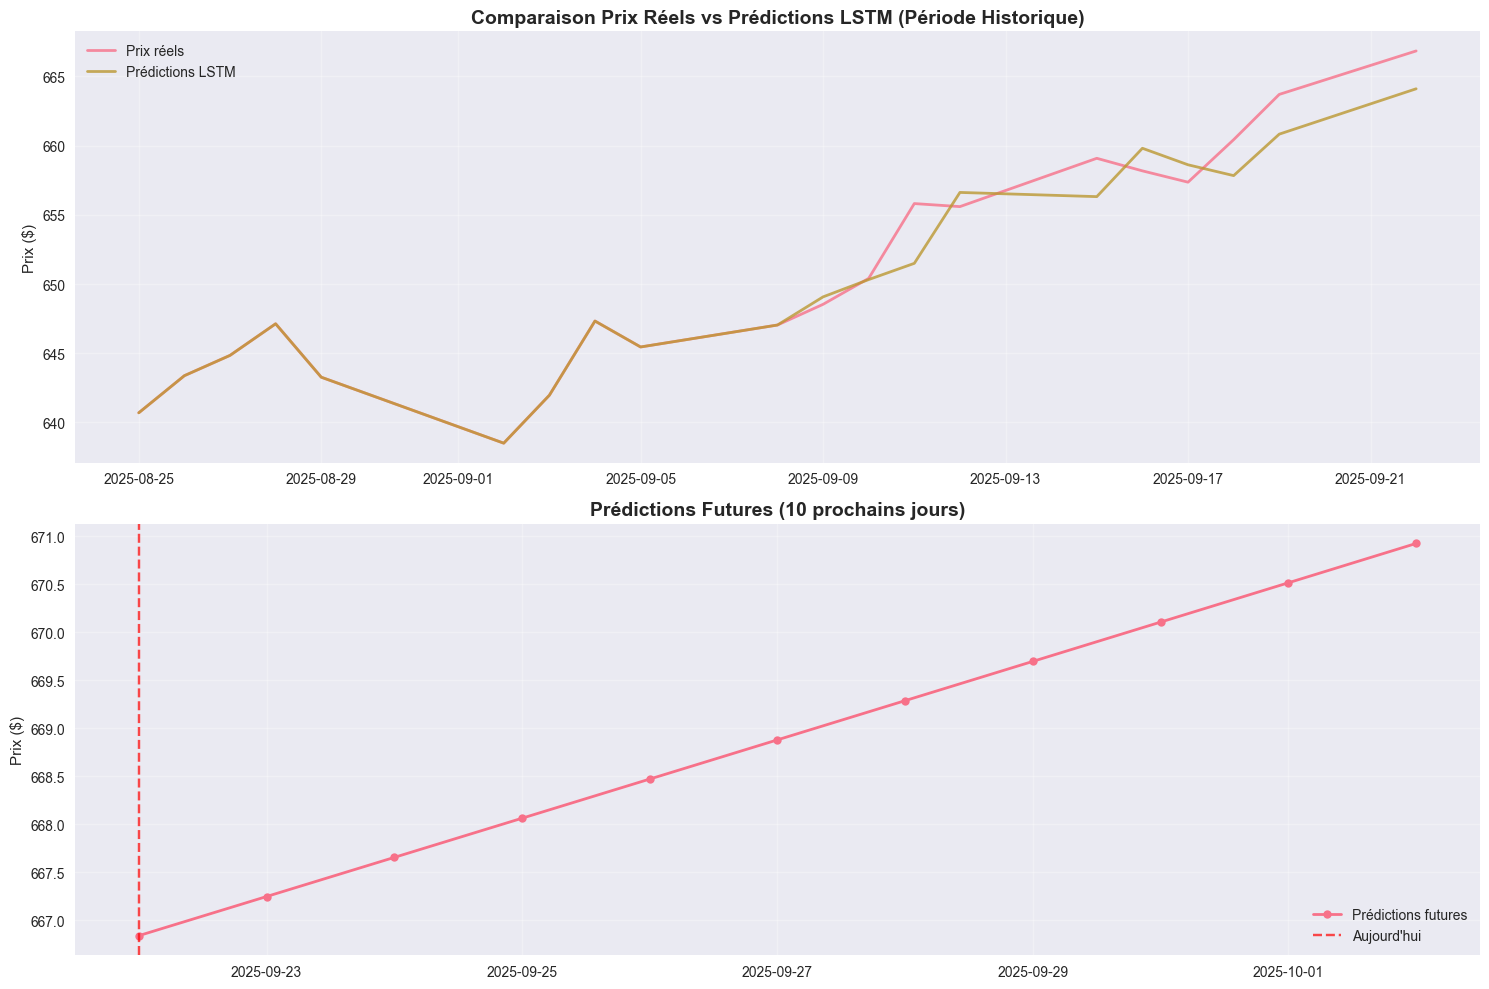

📊 Graphique créé avec succès!


In [9]:
# Visualisation des prédictions
if 'predictions' in locals() and predictions is not None and 'error' not in predictions:
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE_MAIN)
        
        # Graphique 1: Prédictions historiques vs réelles
        dates = filtered_data['DATE']
        real_prices = filtered_data['CLOSE']
        pred_prices = predictions['historical_predictions']
        
        # Vérifier et ajuster les longueurs si nécessaire
        min_length = min(len(dates), len(pred_prices))
        if len(dates) != len(pred_prices):
            print(f"⚠️ Ajustement des longueurs: dates={len(dates)}, prédictions={len(pred_prices)}")
            dates = dates.iloc[:min_length]
            real_prices = real_prices.iloc[:min_length]
            pred_prices = pred_prices[:min_length]
        
        ax1.plot(dates, real_prices, label='Prix réels', linewidth=2, alpha=0.8)
        ax1.plot(dates, pred_prices, label='Prédictions LSTM', linewidth=2, alpha=0.8)
        ax1.set_title('Comparaison Prix Réels vs Prédictions LSTM (Période Historique)', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Prix ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique 2: Prédictions futures
        future_dates = predictions['prediction_dates']
        future_prices = predictions['predictions']
        
        if future_dates and future_prices:
            # Convertir les dates futures en datetime pour le graphique
            future_dates_dt = [pd.to_datetime(d) for d in future_dates]
            
            # Ajouter le dernier prix réel pour la continuité
            last_real_date = dates.iloc[-1]
            last_real_price = real_prices.iloc[-1]
            
            # Normaliser les timezones pour éviter les erreurs de conversion
            if hasattr(last_real_date, 'tz') and last_real_date.tz is not None:
                last_real_date = last_real_date.tz_localize(None)
            
            # Créer les listes pour le graphique
            all_dates = [last_real_date] + future_dates_dt
            all_prices = [last_real_price] + future_prices
            
            ax2.plot(all_dates, all_prices, 'o-', label='Prédictions futures', linewidth=2, markersize=6)
            ax2.axvline(x=last_real_date, color='red', linestyle='--', alpha=0.7, label='Aujourd\'hui')
            ax2.set_title(f'Prédictions Futures ({PREDICTION_HORIZON} prochains jours)', fontsize=14, fontweight='bold')
            ax2.set_ylabel('Prix ($)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        else:
            ax2.text(0.5, 0.5, 'Pas de prédictions futures disponibles', 
                    ha='center', va='center', transform=ax2.transAxes, fontsize=12)
            ax2.set_title('Prédictions Futures - Non Disponibles', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Graphique créé avec succès!")
        
    except Exception as e:
        print(f"❌ Erreur lors de la création du graphique: {e}")
        print(f"🔍 Détails de l'erreur: {type(e).__name__}")
        
else:
    if 'predictions' in locals() and predictions and 'error' in predictions:
        print(f"❌ Erreur dans les prédictions: {predictions['error']}")
    else:
        print("❌ Pas de prédictions disponibles pour la visualisation")


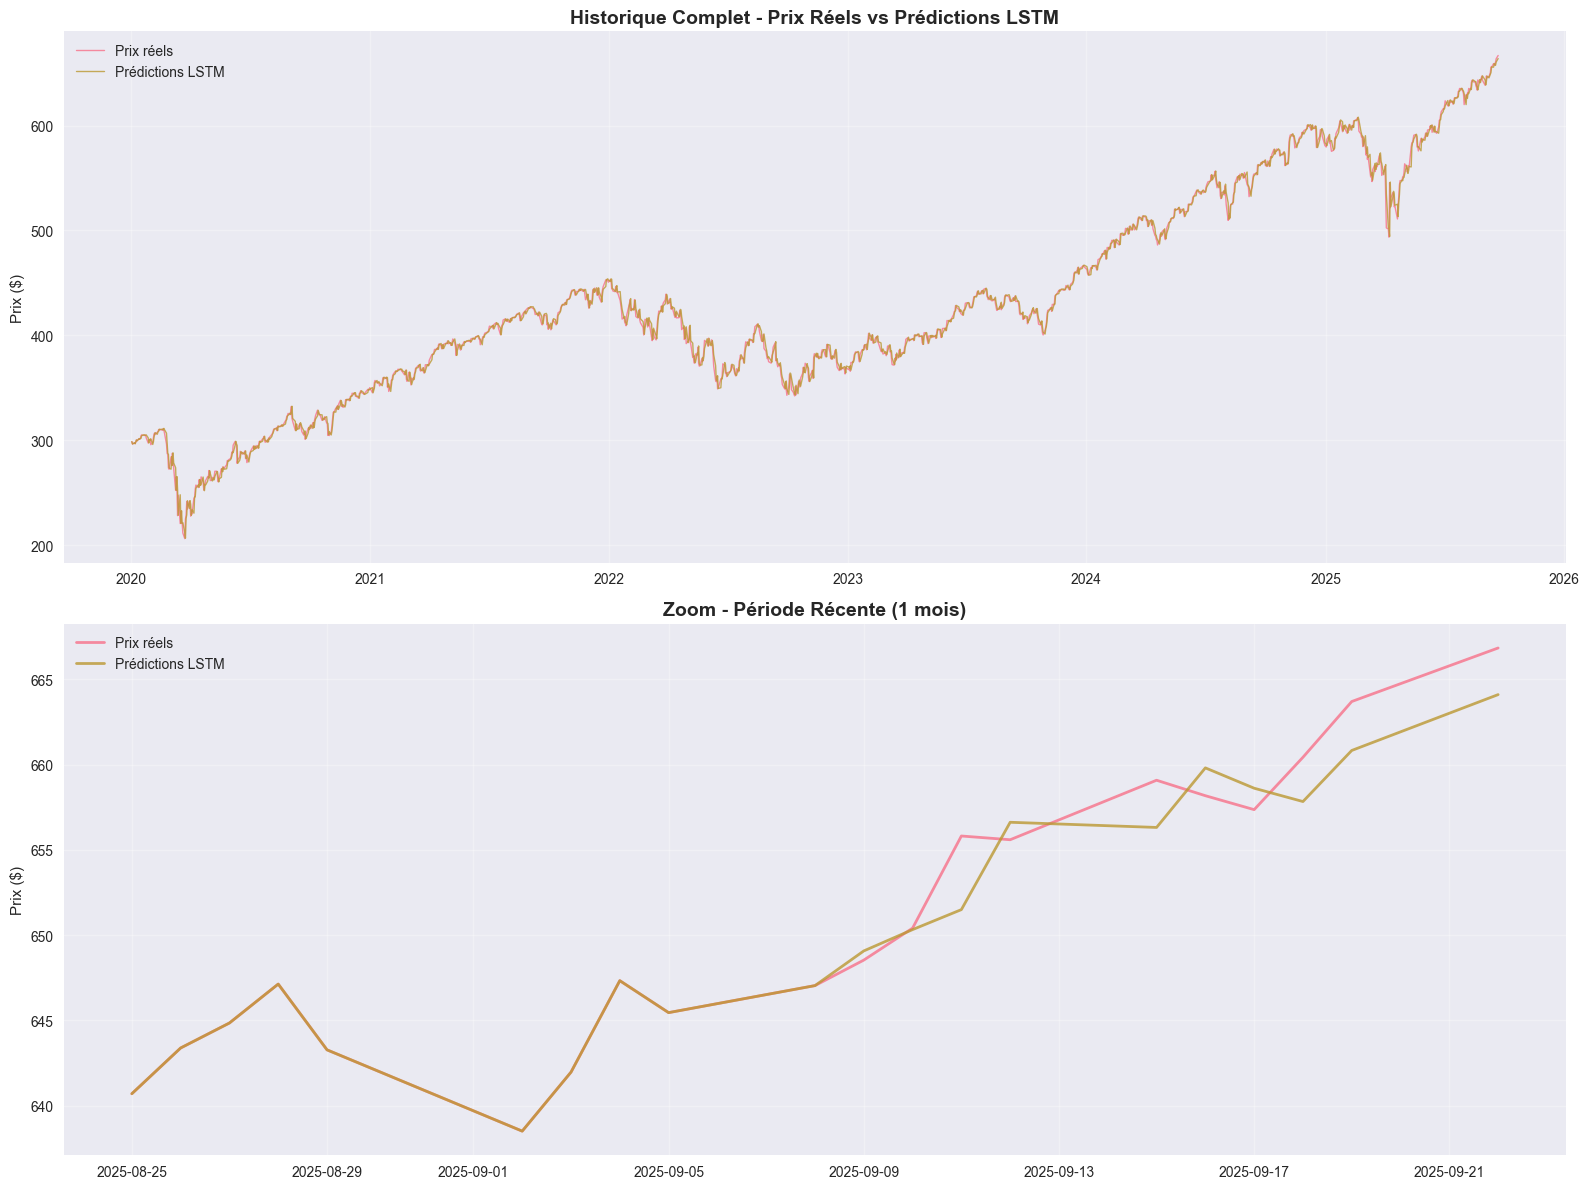

📊 Graphique historique créé avec succès!
📊 MÉTRIQUES DE PERFORMANCE (Période Récente)
📈 MAE (Mean Absolute Error): $0.99
📈 MSE (Mean Squared Error): $2.72
📈 RMSE (Root Mean Squared Error): $1.65
📈 MAPE (Mean Absolute Percentage Error): 0.15%
📈 Corrélation: 0.9832

🔍 ANALYSE DES ERREURS
📊 Erreur moyenne: $0.55
📊 Erreur médiane: $0.00
📊 Erreur std: $1.56
📊 Erreur min: $-1.63
📊 Erreur max: $4.32

📅 PERFORMANCE PAR PÉRIODE
5 derniers jours:
  1. 2025-09-16: Réel $658.18 | Prédit $659.81 | Erreur $-1.63
  2. 2025-09-17: Réel $657.36 | Prédit $658.61 | Erreur $-1.26
  3. 2025-09-18: Réel $660.43 | Prédit $657.83 | Erreur $2.60
  4. 2025-09-19: Réel $663.70 | Prédit $660.83 | Erreur $2.87
  5. 2025-09-22: Réel $666.84 | Prédit $664.11 | Erreur $2.73


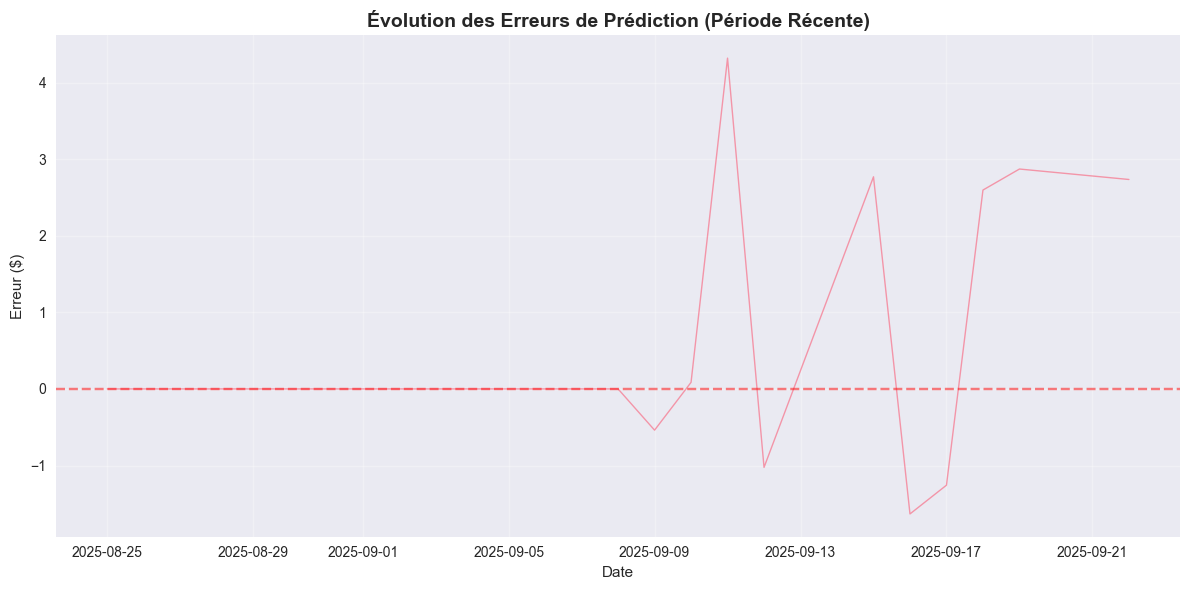

In [10]:
# Visualisation de l'historique complet
if 'historical_predictions' in locals() and historical_predictions is not None and 'error' not in historical_predictions:
    try:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE_FINAL)
        
        # Graphique 1: Historique complet - Prix réels vs Prédictions
        hist_dates = historical_data['DATE']
        hist_real_prices = historical_data['CLOSE']
        hist_pred_prices = historical_predictions['historical_predictions']
        
        # Ajuster les longueurs si nécessaire
        min_length = min(len(hist_dates), len(hist_pred_prices))
        if len(hist_dates) != len(hist_pred_prices):
            hist_dates = hist_dates.iloc[:min_length]
            hist_real_prices = hist_real_prices.iloc[:min_length]
            hist_pred_prices = hist_pred_prices[:min_length]
        
        ax1.plot(hist_dates, hist_real_prices, label='Prix réels', linewidth=1, alpha=0.8)
        ax1.plot(hist_dates, hist_pred_prices, label='Prédictions LSTM', linewidth=1, alpha=0.8)
        ax1.set_title('Historique Complet - Prix Réels vs Prédictions LSTM', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Prix ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique 2: Zoom sur la période récente
        recent_dates = filtered_data['DATE']
        recent_real_prices = filtered_data['CLOSE']
        recent_pred_prices = predictions['historical_predictions']
        
        ax2.plot(recent_dates, recent_real_prices, label='Prix réels', linewidth=2, alpha=0.8)
        ax2.plot(recent_dates, recent_pred_prices, label='Prédictions LSTM', linewidth=2, alpha=0.8)
        ax2.set_title(f'Zoom - Période Récente ({RECENT_PERIOD})', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Prix ($)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        print("📊 Graphique historique créé avec succès!")
        
    except Exception as e:
        print(f"❌ Erreur lors de la création du graphique historique: {e}")

# Analyse des métriques de performance
if 'predictions' in locals() and predictions is not None and 'error' not in predictions:
    historical_preds = predictions['historical_predictions']
    real_prices = filtered_data['CLOSE']
    
    # Convertir en numpy arrays pour les calculs
    real_prices_array = np.array(real_prices)
    historical_preds_array = np.array(historical_preds)
    
    # Calcul des métriques
    mae = np.mean(np.abs(real_prices_array - historical_preds_array))
    mse = np.mean((real_prices_array - historical_preds_array) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((real_prices_array - historical_preds_array) / real_prices_array)) * 100
    
    # Corrélation
    correlation = np.corrcoef(real_prices_array, historical_preds_array)[0, 1]
    
    print("📊 MÉTRIQUES DE PERFORMANCE (Période Récente)")
    print("=" * 50)
    print(f"📈 MAE (Mean Absolute Error): ${mae:.2f}")
    print(f"📈 MSE (Mean Squared Error): ${mse:.2f}")
    print(f"📈 RMSE (Root Mean Squared Error): ${rmse:.2f}")
    print(f"📈 MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"📈 Corrélation: {correlation:.4f}")
    
    # Analyse des erreurs
    errors = real_prices_array - historical_preds_array
    print(f"\n🔍 ANALYSE DES ERREURS")
    print("=" * 50)
    print(f"📊 Erreur moyenne: ${np.mean(errors):.2f}")
    print(f"📊 Erreur médiane: ${np.median(errors):.2f}")
    print(f"📊 Erreur std: ${np.std(errors):.2f}")
    print(f"📊 Erreur min: ${np.min(errors):.2f}")
    print(f"📊 Erreur max: ${np.max(errors):.2f}")
    
    # Performance par période
    print(f"\n📅 PERFORMANCE PAR PÉRIODE")
    print("=" * 50)
    recent_errors = errors[-RECENT_DAYS_DISPLAY:]  # Derniers jours
    recent_dates = filtered_data['DATE'].iloc[-RECENT_DAYS_DISPLAY:]
    recent_real_prices = real_prices_array[-RECENT_DAYS_DISPLAY:]
    recent_pred_prices = historical_preds_array[-RECENT_DAYS_DISPLAY:]
    print(f"{RECENT_DAYS_DISPLAY} derniers jours:")
    for i, (date, real_price, pred_price, error) in enumerate(zip(recent_dates, recent_real_prices, recent_pred_prices, recent_errors), 1):
        print(f"  {i}. {date.strftime('%Y-%m-%d')}: Réel ${real_price:.2f} | Prédit ${pred_price:.2f} | Erreur ${error:.2f}")
    
    # Graphique des erreurs
    plt.figure(figsize=FIGURE_SIZE_ERROR)
    plt.plot(filtered_data['DATE'], errors, alpha=0.7, linewidth=1)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    plt.title('Évolution des Erreurs de Prédiction (Période Récente)', fontsize=14, fontweight='bold')
    plt.ylabel('Erreur ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
elif 'predictions' in locals() and predictions and 'error' in predictions:
    print(f"❌ Erreur dans les prédictions: {predictions['error']}")
else:
    print("❌ Pas de prédictions disponibles pour l'analyse des métriques")


In [11]:
# ANALYSE FINALE - Performance du Modèle sur l'Historique Complet
print("🎯 ANALYSE FINALE - PERFORMANCE DU MODÈLE LSTM")
print("=" * 60)

if 'historical_predictions' in locals() and historical_predictions is not None and 'error' not in historical_predictions:
    # Données complètes
    hist_dates = historical_data['DATE']
    hist_real_prices = historical_data['CLOSE']
    hist_pred_prices = historical_predictions['historical_predictions']
    
    # Ajuster les longueurs
    min_length = min(len(hist_dates), len(hist_pred_prices))
    hist_dates = hist_dates.iloc[:min_length]
    hist_real_prices = hist_real_prices.iloc[:min_length]
    hist_pred_prices = hist_pred_prices[:min_length]
    
    # Calcul des métriques sur l'historique complet
    real_prices_array = np.array(hist_real_prices)
    pred_prices_array = np.array(hist_pred_prices)
    
    # Métriques de performance
    mae_total = np.mean(np.abs(real_prices_array - pred_prices_array))
    mse_total = np.mean((real_prices_array - pred_prices_array) ** 2)
    rmse_total = np.sqrt(mse_total)
    mape_total = np.mean(np.abs((real_prices_array - pred_prices_array) / real_prices_array)) * 100
    correlation_total = np.corrcoef(real_prices_array, pred_prices_array)[0, 1]
    
    # Calcul du pourcentage de réussite
    # On considère une prédiction "réussie" si l'écart est inférieur au seuil configuré
    success_threshold = SUCCESS_THRESHOLD
    price_changes_real = np.diff(real_prices_array) / real_prices_array[:-1]
    price_changes_pred = np.diff(pred_prices_array) / pred_prices_array[:-1]
    
    # Direction correcte (hausse/baisse)
    direction_correct = np.sign(price_changes_real) == np.sign(price_changes_pred)
    direction_accuracy = np.mean(direction_correct) * 100
    
    # Prédictions dans la marge d'erreur
    relative_errors = np.abs((real_prices_array - pred_prices_array) / real_prices_array)
    predictions_within_threshold = np.mean(relative_errors <= success_threshold) * 100
    
    print(f"📊 DONNÉES ANALYSÉES")
    print(f"   • Période: {hist_dates.iloc[0].strftime('%Y-%m-%d')} à {hist_dates.iloc[-1].strftime('%Y-%m-%d')}")
    print(f"   • Nombre de prédictions: {len(hist_real_prices)}")
    print(f"   • Prix min: ${hist_real_prices.min():.2f}")
    print(f"   • Prix max: ${hist_real_prices.max():.2f}")
    
    print(f"\n📈 MÉTRIQUES DE PERFORMANCE GLOBALES")
    print(f"   • MAE (Erreur Absolue Moyenne): ${mae_total:.2f}")
    print(f"   • RMSE (Écart-Type des Erreurs): ${rmse_total:.2f}")
    print(f"   • MAPE (Erreur en Pourcentage): {mape_total:.2f}%")
    print(f"   • Corrélation: {correlation_total:.4f}")
    
    print(f"\n🎯 SCORING DE RÉUSSITE")
    print(f"   • Précision de Direction: {direction_accuracy:.1f}%")
    print(f"   • Prédictions dans la marge (±{SUCCESS_THRESHOLD*100:.0f}%): {predictions_within_threshold:.1f}%")
    print(f"   • Score Global: {(direction_accuracy + predictions_within_threshold) / 2:.1f}%")
    
    # Analyse par période
    print(f"\n📅 ANALYSE PAR PÉRIODE")
    total_days = len(hist_real_prices)
    recent_30_days = min(RECENT_30_DAYS, total_days)
    recent_90_days = min(RECENT_90_DAYS, total_days)
    
    # 30 derniers jours
    recent_30_real = real_prices_array[-recent_30_days:]
    recent_30_pred = pred_prices_array[-recent_30_days:]
    recent_30_mape = np.mean(np.abs((recent_30_real - recent_30_pred) / recent_30_real)) * 100
    
    # 90 derniers jours
    recent_90_real = real_prices_array[-recent_90_days:]
    recent_90_pred = pred_prices_array[-recent_90_days:]
    recent_90_mape = np.mean(np.abs((recent_90_real - recent_90_pred) / recent_90_real)) * 100
    
    print(f"   • 30 derniers jours - MAPE: {recent_30_mape:.2f}%")
    print(f"   • 90 derniers jours - MAPE: {recent_90_mape:.2f}%")
    print(f"   • Historique complet - MAPE: {mape_total:.2f}%")
    
    # Stocker les résultats pour la visualisation
    global final_analysis_results
    final_analysis_results = {
        'dates': hist_dates,
        'real_prices': hist_real_prices,
        'pred_prices': hist_pred_prices,
        'mae': mae_total,
        'rmse': rmse_total,
        'mape': mape_total,
        'correlation': correlation_total,
        'direction_accuracy': direction_accuracy,
        'predictions_within_threshold': predictions_within_threshold,
        'global_score': (direction_accuracy + predictions_within_threshold) / 2
    }
    
else:
    print("❌ Impossible d'analyser l'historique complet - données manquantes")


🎯 ANALYSE FINALE - PERFORMANCE DU MODÈLE LSTM
📊 DONNÉES ANALYSÉES
   • Période: 2020-01-02 à 2025-09-22
   • Nombre de prédictions: 1438
   • Prix min: $206.11
   • Prix max: $666.84

📈 MÉTRIQUES DE PERFORMANCE GLOBALES
   • MAE (Erreur Absolue Moyenne): $3.48
   • RMSE (Écart-Type des Erreurs): $5.04
   • MAPE (Erreur en Pourcentage): 0.87%
   • Corrélation: 0.9987

🎯 SCORING DE RÉUSSITE
   • Précision de Direction: 49.7%
   • Prédictions dans la marge (±2%): 91.9%
   • Score Global: 70.8%

📅 ANALYSE PAR PÉRIODE
   • 30 derniers jours - MAPE: 0.43%
   • 90 derniers jours - MAPE: 0.49%
   • Historique complet - MAPE: 0.87%


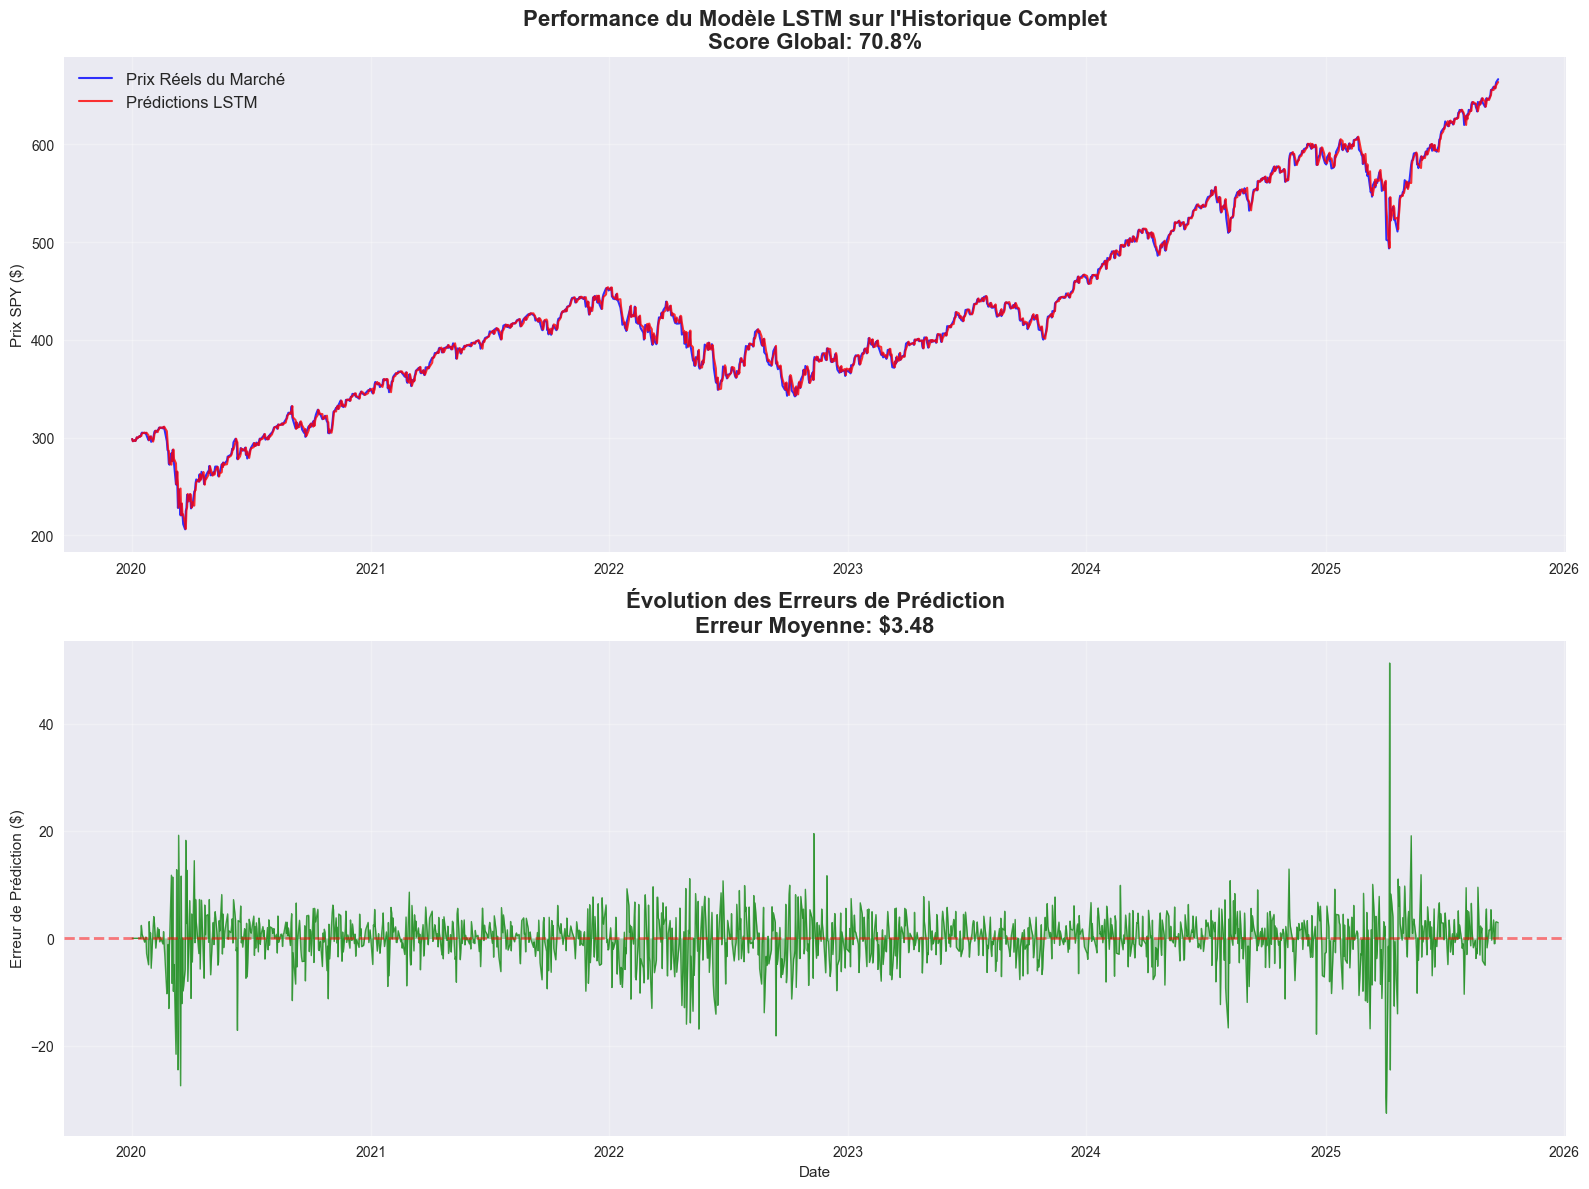


🏆 RÉSULTAT FINAL DU MODÈLE LSTM - ANALYSE COMPLÈTE
📅 PÉRIODE ANALYSÉE:
   • Début: 02/01/2020
   • Fin: 22/09/2025
   • Durée: 1438 jours de trading
   • Prix initial: $298.58
   • Prix final: $666.84

📊 SCORE DE PERFORMANCE:
   • Score Global: 70.8% sur 100%
   • Précision Direction: 49.7% (hausse/baisse correcte)
   • Prédictions Précises: 91.9% (à ±2% du prix réel)

📈 MÉTRIQUES TECHNIQUES:
   • Erreur Moyenne: 0.87% du prix
   • Corrélation: 0.999 (1.000 = parfait)
   • Écart-Type: $5.04

🥈 VERDICT: BONNE
💡 Le modèle suit correctement les mouvements du marché
🎯 Votre modèle LSTM a un taux de réussite de 70.8% par rapport au marché réel


In [12]:
# VISUALISATION FINALE - Graphique de Performance et Confirmation du Score
if 'final_analysis_results' in locals() and final_analysis_results:
    try:
        # Créer une figure avec 2 graphiques principaux
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=FIGURE_SIZE_FINAL)
        
        dates = final_analysis_results['dates']
        real_prices = final_analysis_results['real_prices']
        pred_prices = final_analysis_results['pred_prices']
        
        # Graphique 1: Comparaison Prix Réels vs Prédictions (Historique Complet)
        ax1.plot(dates, real_prices, label='Prix Réels du Marché', linewidth=1.5, alpha=0.8, color='blue')
        ax1.plot(dates, pred_prices, label='Prédictions LSTM', linewidth=1.5, alpha=0.8, color='red')
        ax1.set_title(f'Performance du Modèle LSTM sur l\'Historique Complet\nScore Global: {final_analysis_results["global_score"]:.1f}%', 
                     fontsize=16, fontweight='bold')
        ax1.set_ylabel('Prix SPY ($)')
        ax1.legend(fontsize=12)
        ax1.grid(True, alpha=0.3)
        
        # Graphique 2: Erreurs de Prédiction dans le Temps
        errors = real_prices - pred_prices
        ax2.plot(dates, errors, linewidth=1, alpha=0.7, color='green')
        ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=2)
        ax2.fill_between(dates, errors, alpha=0.3, color='green')
        ax2.set_title(f'Évolution des Erreurs de Prédiction\nErreur Moyenne: ${final_analysis_results["mae"]:.2f}', 
                     fontsize=16, fontweight='bold')
        ax2.set_ylabel('Erreur de Prédiction ($)')
        ax2.set_xlabel('Date')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Affichage du score final de manière compréhensible
        print("\n" + "="*70)
        print("🏆 RÉSULTAT FINAL DU MODÈLE LSTM - ANALYSE COMPLÈTE")
        print("="*70)
        
        # Informations sur la période analysée
        print(f"📅 PÉRIODE ANALYSÉE:")
        print(f"   • Début: {dates.iloc[0].strftime('%d/%m/%Y')}")
        print(f"   • Fin: {dates.iloc[-1].strftime('%d/%m/%Y')}")
        print(f"   • Durée: {len(dates)} jours de trading")
        print(f"   • Prix initial: ${real_prices.iloc[0]:.2f}")
        print(f"   • Prix final: ${real_prices.iloc[-1]:.2f}")
        
        # Score de performance
        score = final_analysis_results['global_score']
        print(f"\n📊 SCORE DE PERFORMANCE:")
        print(f"   • Score Global: {score:.1f}% sur 100%")
        print(f"   • Précision Direction: {final_analysis_results['direction_accuracy']:.1f}% (hausse/baisse correcte)")
        print(f"   • Prédictions Précises: {final_analysis_results['predictions_within_threshold']:.1f}% (à ±{SUCCESS_THRESHOLD*100:.0f}% du prix réel)")
        
        # Métriques techniques
        print(f"\n📈 MÉTRIQUES TECHNIQUES:")
        print(f"   • Erreur Moyenne: {final_analysis_results['mape']:.2f}% du prix")
        print(f"   • Corrélation: {final_analysis_results['correlation']:.3f} (1.000 = parfait)")
        print(f"   • Écart-Type: ${final_analysis_results['rmse']:.2f}")
        
        # Interprétation du score
        if score >= 90:
            performance = "EXCELLENTE"
            emoji = "🏆"
            interpretation = "Le modèle prédit très bien les mouvements du marché"
        elif score >= 80:
            performance = "TRÈS BONNE"
            emoji = "🥇"
            interpretation = "Le modèle prédit bien les tendances du marché"
        elif score >= 70:
            performance = "BONNE"
            emoji = "🥈"
            interpretation = "Le modèle suit correctement les mouvements du marché"
        elif score >= 60:
            performance = "MOYENNE"
            emoji = "🥉"
            interpretation = "Le modèle a des prédictions correctes mais perfectibles"
        else:
            performance = "À AMÉLIORER"
            emoji = "⚠️"
            interpretation = "Le modèle nécessite des améliorations"
        
        print(f"\n{emoji} VERDICT: {performance}")
        print(f"💡 {interpretation}")
        print(f"🎯 Votre modèle LSTM a un taux de réussite de {score:.1f}% par rapport au marché réel")
        
    except Exception as e:
        print(f"❌ Erreur lors de la création de la visualisation finale: {e}")
        print(f"🔍 Détails: {type(e).__name__}")
        
else:
    print("❌ Impossible de créer la visualisation finale - analyse manquante")
